In [1]:
import os
os.chdir("../")

In [2]:
from src.entity import AgentState, SessionLocal
from langgraph.graph import StateGraph, END
from src.get_current_user import get_current_user
from src.check_revelance import check_relevance
from src.convert_to_sql import convert_nl_to_sql
from sqlalchemy import text

In [3]:
def relevance_router(state: AgentState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "END"

In [4]:
def execute_sql(state: AgentState):
    sql_query = state["sql_query"].strip()
    session = SessionLocal()
    print(f"Executing SQL query: {sql_query}")
    try:
        result = session.execute(text(sql_query))
        if sql_query.lower().startswith("select"):
            rows = result.fetchall()
            columns = result.keys()
            if rows:
                header = ", ".join(columns)
                state["query_rows"] = [dict(zip(columns, row)) for row in rows]
                print(f"Raw SQL Query Result: {state['query_rows']}")
                # Format the result for readability
                data = "; ".join([f"{row.get('food_name', row.get('name'))} for ${row.get('price', row.get('food_price'))}" for row in state["query_rows"]])
                formatted_result = f"{header}\n{data}"
            else:
                state["query_rows"] = []
                formatted_result = "No results found."
            state["query_result"] = formatted_result
            state["sql_error"] = False
            print("SQL SELECT query executed successfully.")
        else:
            session.commit()
            state["query_result"] = "The action has been successfully completed."
            state["sql_error"] = False
            print("SQL command executed successfully.")
    except Exception as e:
        state["query_result"] = f"Error executing SQL query: {str(e)}"
        state["sql_error"] = True
        print(f"Error executing SQL query: {str(e)}")
    finally:
        session.close()
    return state

In [5]:
workflow = StateGraph(AgentState)

workflow.add_node("get_current_user", get_current_user)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_sql)

workflow.add_edge("get_current_user", "check_relevance")
workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_to_sql": "convert_to_sql",
        "END": END,
    },
)
workflow.add_edge("convert_to_sql", "execute_sql")
workflow.add_edge("execute_sql", END)
workflow.set_entry_point("get_current_user")

app = workflow.compile()

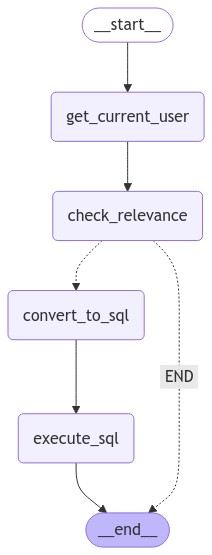

In [6]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    pass

In [7]:
config = {"configurable": {"current_user_id": "2"}}
user_question_1 = "how much does food 3 cost?"
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=config)
print("Result:", result_1)

Retrieving the current user based on user ID.
Current user set to: User 2
Retrieved database schema.
Checking relevance of the question: how much does food 3 cost?
Relevance determined: relevant
Retrieved database schema.
Converting question to SQL for user 'User 2': how much does food 3 cost?
Generated SQL query: SELECT food.price FROM food WHERE food.id = 3;
Executing SQL query: SELECT food.price FROM food WHERE food.id = 3;
Raw SQL Query Result: [{'price': 42.0}]
SQL SELECT query executed successfully.
Result: {'question': 'how much does food 3 cost?', 'sql_query': 'SELECT food.price FROM food WHERE food.id = 3;', 'query_result': 'price\nNone for $42.0', 'query_rows': [{'price': 42.0}], 'current_user': 'User 2', 'attempts': 0, 'relevance': 'relevant', 'sql_error': False}


In [9]:
print(result_1['query_result'])

price
None for $42.0
